In [1]:
import findspark
findspark.init()
from pathlib import Path
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, avg, count, row_number, expr, when, from_unixtime, floor
from pyspark.sql.window import Window
# from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, LongType
# from pyspark.sql.functions import col, regexp_replace, length, desc, row_number

In [2]:
conf = SparkConf().setAppName("feature-matrix")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [3]:
def shape(df):
    return (df.count(), len(df.columns))

## carregando arquivos Parquet no HDFS

In [4]:
bus_api_folder = Path.cwd().parent / "datasets" / "bus-api-parquet"

In [5]:
str(bus_api_folder)

'/root/lab/datasets/bus-api-parquet'

In [6]:
! hadoop fs -mkdir /user/root/bus-api-parquet

23/09/22 18:30:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
! hadoop fs -put /root/lab/datasets/bus-api-parquet/*.parquet /user/root/bus-api-parquet/

23/09/22 18:30:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
! hadoop fs -ls /user/root/bus-api-parquet/

23/09/22 18:30:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 176 items
-rw-r--r--   2 root supergroup    2222629 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-15_000000.jsonl.parquet
-rw-r--r--   2 root supergroup    2113077 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-15_010000.jsonl.parquet
-rw-r--r--   2 root supergroup    2135617 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-15_020000.jsonl.parquet
-rw-r--r--   2 root supergroup    2509609 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-15_030000.jsonl.parquet
-rw-r--r--   2 root supergroup    3586780 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-15_040000.jsonl.parquet
-rw-r--r--   2 root supergroup    4838785 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-15_050000.jsonl.parquet
-rw-r--r--   2 root supergroup    5411458 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-15_060000.jsonl.parquet
-rw-r--r--

-rw-r--r--   2 root supergroup    5281862 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-18_140000.jsonl.parquet
-rw-r--r--   2 root supergroup    5378069 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-18_150000.jsonl.parquet
-rw-r--r--   2 root supergroup    5503691 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-18_160000.jsonl.parquet
-rw-r--r--   2 root supergroup    5587071 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-18_170000.jsonl.parquet
-rw-r--r--   2 root supergroup    5522931 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-18_180000.jsonl.parquet
-rw-r--r--   2 root supergroup    2834894 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-19_000000.jsonl.parquet
-rw-r--r--   2 root supergroup    2433368 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-19_020000.jsonl.parquet
-rw-r--r--   2 root supergroup    2621753 2023-09-22 18:30 /user/root/bus-api-parquet/2023-05-19_030000.jsonl.parquet
-rw-r--r--   2 root supergroup    3667391 2023-09-22 18:

## lendo arquivos Parquet em único DataFrame

In [9]:
hdfs_src_path = "/user/root/bus-api-parquet/"

In [10]:
df = spark.read.format(
    "parquet"
).load(
    f"{hdfs_src_path}/*.parquet"
)

#### 75MM de registros

In [11]:
shape(df)

(75212501, 8)

In [12]:
df.printSchema()

root
 |-- ordem: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- datahora: long (nullable = true)
 |-- velocidade: long (nullable = true)
 |-- linha: string (nullable = true)
 |-- datahoraenvio: long (nullable = true)
 |-- datahoraservidor: long (nullable = true)



In [13]:
df = df.select("ordem", "latitude", "longitude", "velocidade", "linha", "datahoraservidor")

## calculando o número de veículos únicos

In [14]:
df_uniq_vehicles = df.select("ordem").distinct()

In [15]:
shape(df_uniq_vehicles)

(3885, 1)

## feature velocidade

#### média

In [16]:
df_avg_speed = df.filter(
    col("velocidade") > 0
).groupBy(
    "ordem"
).agg(
    avg(col("velocidade")).alias("avg_velocidade")
).orderBy(
    # col("ordem").asc()
    col("avg_velocidade").desc()
)

In [17]:
shape(df_avg_speed)

(3878, 2)

In [18]:
df_avg_speed.show(100)

+------+------------------+
| ordem|    avg_velocidade|
+------+------------------+
|B32537| 65.81964615790864|
|B44616| 49.35725505595916|
|B32623| 48.54131118096093|
|B32666| 46.99263664684226|
|B44618|45.361522430624106|
|B32588| 44.59836229279009|
|C47865|44.424344176285416|
|C47828| 43.95595290013083|
|C47824| 43.69706709521896|
|B63107| 43.63815028901734|
|C47861| 43.62799740764744|
|C27022| 43.56431724767849|
|C47656| 42.99435435435436|
|C47860| 42.62111197511664|
|C47867| 42.58265424912689|
|B32548| 42.46973803071364|
|A63526|42.175174637291775|
|C12015| 41.90256554044581|
|C47739|41.731054977711736|
|B32668| 41.64514731369151|
|B32502| 41.61483198146002|
|A29158| 41.59293937068304|
|D17513| 41.39940514127895|
|A29065| 41.20642102995044|
|B63025|41.188235294117646|
|D12173| 41.15859247135843|
|C47869|41.139361910354275|
|A63525|41.051159072741804|
|A63515|40.982236842105266|
|A50079|40.980530474040634|
|A29068|40.956389259188725|
|B32558| 40.89928719245803|
|C41355| 40.89076699

#### moda

In [19]:
df_mode_speed_pre = df.filter(
    col("velocidade") > 0
).groupBy(
    "ordem", "velocidade"
).agg(
    count(col("velocidade")).alias("count_velocidade")
).orderBy(
    col("ordem").asc()
)

In [20]:
shape(df_mode_speed_pre)

(265773, 3)

In [21]:
window_by_ordem = Window.partitionBy("ordem").orderBy(col("count_velocidade").desc())

In [22]:
df_mode_speed = df_mode_speed_pre.withColumn(
    "row_number", row_number().over(window_by_ordem)
).filter(
    # col("row_number").isin(1, 2, 3)
    # ((col("row_number") == 2) | (col("row_number") == 1))
    col("row_number") == 1
).orderBy(
    # col("ordem").asc(), col("row_number").asc()
    col("velocidade").desc()
)

In [23]:
shape(df_mode_speed)

(3878, 4)

In [24]:
df_mode_speed.show(100)

+------+----------+----------------+----------+
| ordem|velocidade|count_velocidade|row_number|
+------+----------+----------------+----------+
|B32537|        96|            1702|         1|
|D12113|        83|             136|         1|
|B32805|        81|             327|         1|
|B32502|        81|             169|         1|
|B32803|        81|             252|         1|
|D53505|        81|             299|         1|
|D87826|        81|             374|         1|
|C41092|        80|             128|         1|
|C41112|        79|             177|         1|
|D53912|        79|             205|         1|
|B32806|        79|             161|         1|
|C41355|        79|             173|         1|
|B32802|        79|             265|         1|
|D53916|        78|             281|         1|
|D53930|        78|             237|         1|
|C41325|        78|             196|         1|
|B31132|        78|              87|         1|
|B32801|        78|             120|    

#### mediana

In [25]:
# amostra de tamanho ímpar
vel = [0, 34, 67, 98, 100]
# amostra de tamanho = len(vel) = 5
# mediana = posicao do meio = vel[len(vel) // 2] = 67

In [26]:
5//2

2

In [27]:
vel[len(vel) // 2]

67

In [28]:
# amostra de tamanho par
vel = [0, 34, 52, 67, 98, 100]
# mediana = (52 + 67) / 2 = 59.5

In [29]:
# median = expr("percentile_approx(velocidade, 0.5)")

In [30]:
# df_median_speed = df.filter(
#     col("velocidade") > 0
# ).groupBy(
#     "ordem"
# ).agg(
#     median.alias("median_velocidade")
# ).orderBy(
#     # col("ordem").asc()
#     col("median_velocidade").desc()
# )

In [31]:
# shape(df_median_speed)

In [32]:
# df_median_speed.show(100)

## feature período circulação

In [33]:
df_period_pre = df.filter(
    col("velocidade") > 0
).withColumn(
    "dt_wrong", from_unixtime(col("datahoraservidor"), "yyyy-MM-dd HH:mm:ss")
).withColumn(
    "dt", from_unixtime(floor(col("datahoraservidor") / 1000), "yyyy-MM-dd HH:mm:ss")
).withColumn(
    "hora", from_unixtime(floor(col("datahoraservidor") / 1000), "HHmm").cast("int")
).withColumn(
    "periodo",
    expr(
        """
        case
        when hora >= 0 and hora <= 559 then 'Madrugada'
        when hora >= 600 and hora <= 1159 then 'Manhã'
        when hora >= 1200 and hora <= 1759 then 'Tarde'
        when hora >= 1800 and hora <= 2359 then 'Noite'
        else 'Erro'
        end
        """
    )
).select("ordem", "latitude", "longitude", "velocidade", "linha", "dt_wrong", "dt", "hora", "periodo")

In [34]:
df_period_pre_2 = df_period_pre.groupBy(
    "ordem", "periodo"
).agg(
    count(col("periodo")).alias("count_periodo")
).orderBy(
    col("ordem").desc()
)

In [35]:
# veiculo: D87893
# Madrugada 194
# Manhã     1458
# Tarde     1499
# Noite     1328

instances = [194, 1458, 1499, 1328]

In [36]:
percent_instances = [i / sum(instances) for i in instances]

In [37]:
percent_instances

[0.04331323956240232,
 0.32551908908238447,
 0.33467291806206745,
 0.2964947532931458]

In [38]:
window_by_ordem = Window.partitionBy("ordem").orderBy(col("count_periodo").desc())

In [39]:
df_period = df_period_pre_2.withColumn(
    "row_number", row_number().over(window_by_ordem)
).filter(
    col("row_number") == 1
).orderBy(
    col("ordem").asc()
)

In [40]:
df_period.show(100)

+------+---------+-------------+----------+
| ordem|  periodo|count_periodo|row_number|
+------+---------+-------------+----------+
| 29107|    Noite|         3329|         1|
|     A|    Tarde|         2627|         1|
|A27509|    Noite|         1642|         1|
|A27515|    Noite|         2600|         1|
|A27517|    Tarde|         2334|         1|
|A27522|    Noite|         2444|         1|
|A27537|    Noite|         2711|         1|
|A27544|    Noite|         3128|         1|
|A27556|    Noite|         2338|         1|
|A27559|    Noite|         2780|         1|
|A27560|    Noite|         2636|         1|
|A27565|    Manhã|         2667|         1|
|A27567|    Noite|         2372|         1|
|A27571|    Noite|         2741|         1|
|A27574|    Noite|         3033|         1|
|A27582|    Noite|         2903|         1|
|A27588|    Noite|         2792|         1|
|A27589|    Noite|         2506|         1|
|A27594|    Noite|         2588|         1|
|A27597|    Manhã|         3039|

## montagem Matriz de Features

In [41]:
df_features_1 = df_uniq_vehicles.join(
    df_avg_speed, df_uniq_vehicles.ordem == df_avg_speed.ordem, "left"
).select(
    df_uniq_vehicles.ordem, col("avg_velocidade")
).join(
    df_period, df_uniq_vehicles.ordem == df_period.ordem, "left"
).select(
    df_uniq_vehicles.ordem, col("avg_velocidade"), col("periodo")
)

In [42]:
# ordem | baixa | moderada | alta | madrugada | manha | tarde | noite

In [43]:
df_features = df_features_1.withColumn(
    "baixa",
    when(col("avg_velocidade") <= 30, 1).otherwise(0)
).withColumn(
    "moderada",
    expr("case when avg_velocidade > 30 and avg_velocidade <= 60 then 1 else 0 end")
).withColumn(
    "alta",
    when(col("avg_velocidade") > 60, 1).otherwise(0)
).withColumn(
    "madrugada",
    when(col("periodo") == "Madrugada", 1).otherwise(0)
).withColumn(
    "manha",
    when(col("periodo") == "Manhã", 1).otherwise(0)
).withColumn(
    "tarde",
    when(col("periodo") == "Tarde", 1).otherwise(0)
).withColumn(
    "noite",
    when(col("periodo") == "Noite", 1).otherwise(0)
).select(
    "ordem", "baixa", "moderada", "alta", "madrugada", "manha", "tarde", "noite"
)

In [44]:
df_features.printSchema()

root
 |-- ordem: string (nullable = true)
 |-- baixa: integer (nullable = false)
 |-- moderada: integer (nullable = false)
 |-- alta: integer (nullable = false)
 |-- madrugada: integer (nullable = false)
 |-- manha: integer (nullable = false)
 |-- tarde: integer (nullable = false)
 |-- noite: integer (nullable = false)



In [45]:
df_features.show(50)

+------+-----+--------+----+---------+-----+-----+-----+
| ordem|baixa|moderada|alta|madrugada|manha|tarde|noite|
+------+-----+--------+----+---------+-----+-----+-----+
|A41017|    1|       0|   0|        0|    0|    0|    1|
|A41140|    0|       1|   0|        0|    1|    0|    0|
|A41179|    0|       1|   0|        0|    0|    0|    1|
|A48130|    1|       0|   0|        0|    0|    0|    1|
|A50019|    1|       0|   0|        0|    0|    1|    0|
|A72062|    1|       0|   0|        0|    0|    0|    1|
|B10550|    1|       0|   0|        0|    0|    1|    0|
|B11580|    1|       0|   0|        0|    0|    0|    1|
|B25529|    1|       0|   0|        0|    0|    0|    1|
|B27144|    1|       0|   0|        0|    0|    0|    1|
|B32501|    1|       0|   0|        0|    1|    0|    0|
|B32526|    1|       0|   0|        0|    0|    1|    0|
|B58031|    1|       0|   0|        0|    0|    0|    1|
|B58132|    1|       0|   0|        0|    0|    1|    0|
|B63038|    0|       1|   0|   

## inicio Clusterização

In [46]:
! pip install scikit-learn seaborn

     |################################| 292 kB 4.2 MB/s            


In [47]:
import seaborn as sns

In [48]:
dff = df_features.toPandas()

In [49]:
dff.shape

(3885, 8)

In [50]:
from sklearn.manifold import TSNE

In [51]:
dff["id"] = dff.index

In [52]:
dff.columns

Index(['ordem', 'baixa', 'moderada', 'alta', 'madrugada', 'manha', 'tarde',
       'noite', 'id'],
      dtype='object')

In [59]:
dff_features = dff[["baixa", "moderada", "alta", "madrugada", "manha", "tarde", "noite"]]

In [60]:
dff_features.head()

,baixa,moderada,alta,madrugada,manha,tarde,noite
0,1,0,0,0,0,0,1
1,0,1,0,0,1,0,0
2,0,1,0,0,0,0,1
3,1,0,0,0,0,0,1
4,1,0,0,0,0,1,0


In [61]:
matrix = dff_features.to_numpy()

In [80]:
r_tsne = TSNE(n_components=2, random_state=1, perplexity=10, verbose=1).fit_transform(matrix)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3885 samples in 0.014s...
[t-SNE] Computed neighbors for 3885 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3885
[t-SNE] Computed conditional probabilities for sample 2000 / 3885
[t-SNE] Computed conditional probabilities for sample 3000 / 3885
[t-SNE] Computed conditional probabilities for sample 3885 / 3885
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.907555
[t-SNE] KL divergence after 1000 iterations: 2.506468


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

No handles with labels found to put in legend.


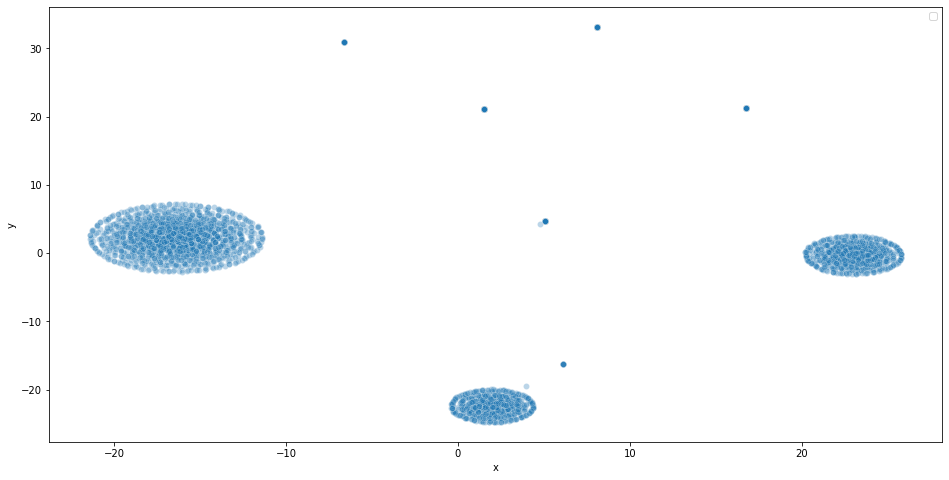

In [82]:
df_tsne = pd.DataFrame()
df_tsne['x'] = r_tsne[:,0]
df_tsne['y'] = r_tsne[:,1]
plt.figure(figsize=(16,8))
sns.scatterplot(
    x='x',
    y='y',
    # hue=predicao,
    # palette=sns.color_palette("hls", len(set(predicao))),
    data=df_tsne,
    legend="full",
    alpha=0.3
)
plt.legend(loc='upper right')
plt.show()

In [84]:
from sklearn.cluster import KMeans

In [101]:
kmeans = KMeans(n_clusters=8, verbose=1, random_state=0)
kmeans.fit(matrix)

Initialization complete
Iteration 0, inertia 16.0
Iteration 1, inertia 15.932384341637391
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.0
Iteration 1, inertia 15.932384341637391
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 30.0
Iteration 1, inertia 29.469793969966513
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.0
Iteration 1, inertia 15.885644842483826
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.0
Iteration 1, inertia 15.932384341637391
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.0
Iteration 1, inertia 15.932384341637391
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.0
Iteration 1, inertia 15.630387762138815
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16.

KMeans(random_state=0, verbose=1)

In [102]:
prediction = kmeans.labels_

In [103]:
len(prediction)

3885

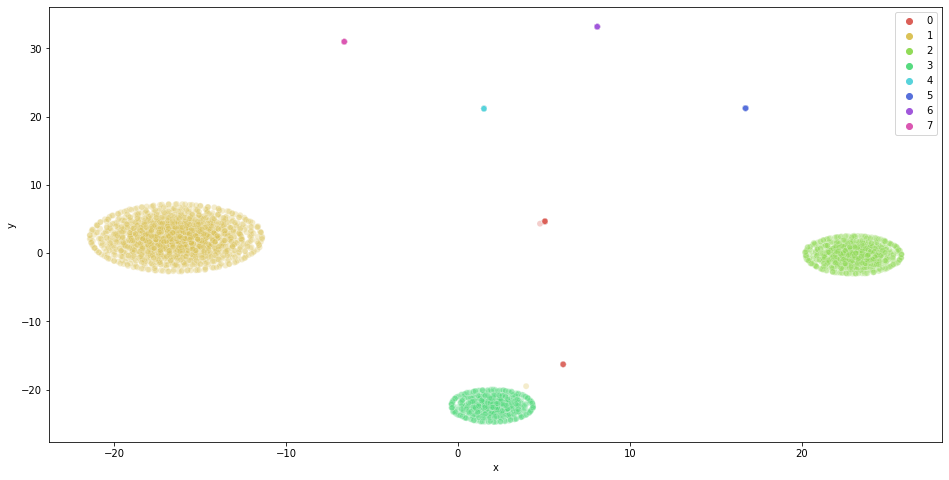

In [104]:
df_tsne = pd.DataFrame()
df_tsne['x'] = r_tsne[:,0]
df_tsne['y'] = r_tsne[:,1]
plt.figure(figsize=(16,8))
sns.scatterplot(
    x='x',
    y='y',
    hue=prediction,
    palette=sns.color_palette("hls", len(set(prediction))),
    data=df_tsne,
    legend="full",
    alpha=0.3
)
plt.legend(loc='upper right')
plt.show()